# Import Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Import Data

In [36]:
train_df = pd.read_csv("../../data/train_data_v2.csv")
validate_df = pd.read_csv("../../data/validate_data_v2.csv")
test_df = pd.read_csv("../../data/test_data_v2.csv")

In [37]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 74)
(1000, 74)
(1000, 74)


# Evaluation Function

In [38]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    # Accuracy1: Exact match (diagonal of confusion matrix)
    acc1 = np.mean(y_pred == y_test)
    print("Accuracy1 (Exact match):", acc1)

    # Accuracy2: One-off accuracy (prediction is within ±1 of true label)
    one_off = np.abs(y_pred - y_test) <= 1
    acc2 = np.mean(one_off)
    print("Accuracy2 (One-off accuracy):", acc2)


    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Feature Importance Function

In [53]:
def plot_top_feature_importances(model, X, selector=None, top_n=10):
    """
    Plots the top N feature importances from a trained model.
    
    Parameters:
    - model: Trained sklearn model with feature_importances_ attribute
    - X: Original (full) training feature DataFrame
    - selector: RFE selector used to reduce features (optional)
    - top_n: Number of top features to display
    """
    if selector is not None:
        # Filter features using RFE support mask
        feature_names = X.columns[selector.support_]
    else:
        feature_names = X.columns

    # Create a DataFrame with importances and feature names
    importances = model.feature_importances_
    feat_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='skyblue')
    plt.xlabel("Feature Importance Score")
    plt.ylabel(f"Top {top_n} Features")
    plt.title(f"Top {top_n} Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Define Features & Target

In [54]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [55]:

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_validate)

Accuracy: 0.526
F1 Score: 0.5969071479254632
Classification Report:
               precision    recall  f1-score   support

           1       0.20      1.00      0.33        14
           2       0.98      0.47      0.64       828
           3       0.35      0.75      0.47       124
           4       0.11      0.85      0.19        34

    accuracy                           0.53      1000
   macro avg       0.41      0.77      0.41      1000
weighted avg       0.86      0.53      0.60      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 48 390 171 219]
 [  8   7  93  16]
 [  0   1   4  29]]
Accuracy1 (Exact match): 0.526
Accuracy2 (One-off accuracy): 0.772


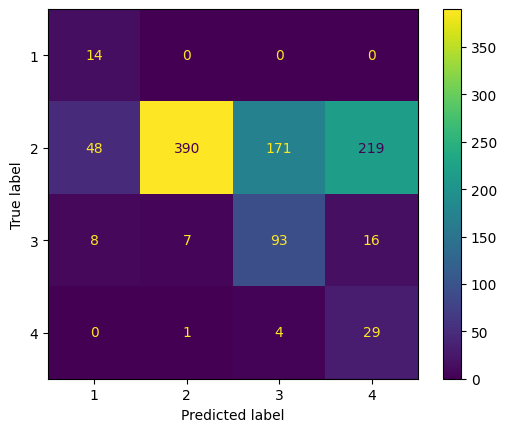

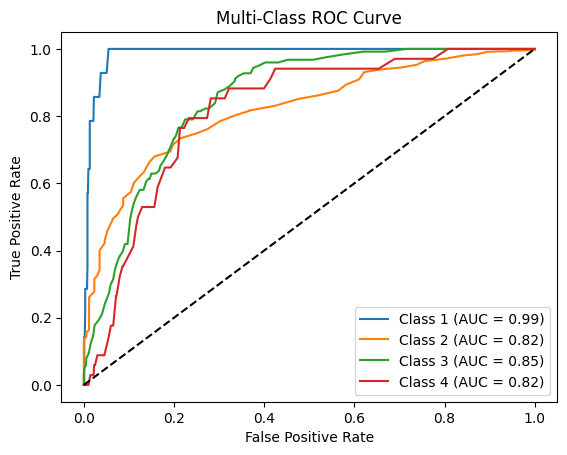

In [56]:
evaluate(y_pred, y_validate, X_validate, model)


Accuracy: 0.504
F1 Score: 0.6017220698422082
Classification Report:
               precision    recall  f1-score   support

           1       0.10      1.00      0.17         6
           2       0.97      0.48      0.64       857
           3       0.32      0.65      0.43       119
           4       0.05      0.72      0.09        18

    accuracy                           0.50      1000
   macro avg       0.36      0.71      0.33      1000
weighted avg       0.87      0.50      0.60      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 41 408 161 247]
 [ 15   9  77  18]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.504
Accuracy2 (One-off accuracy): 0.735


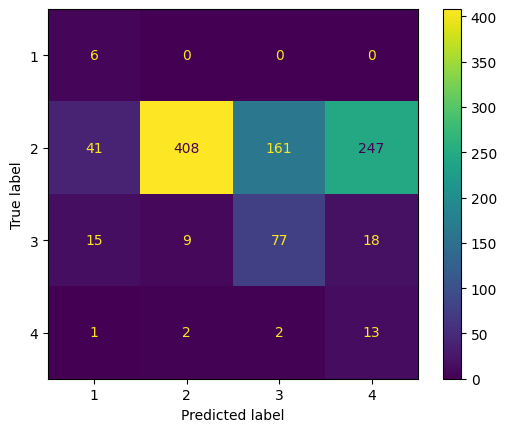

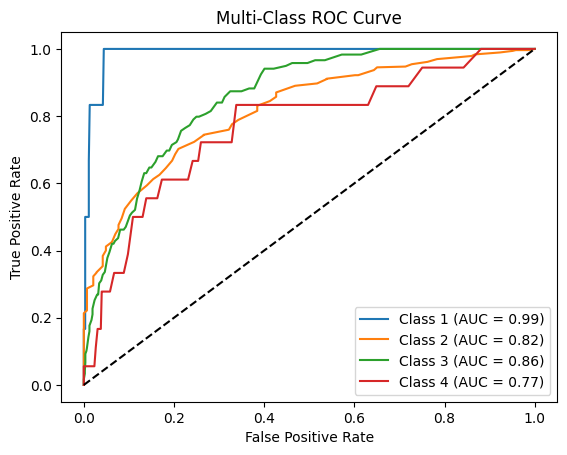

In [57]:
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, X_test, model)


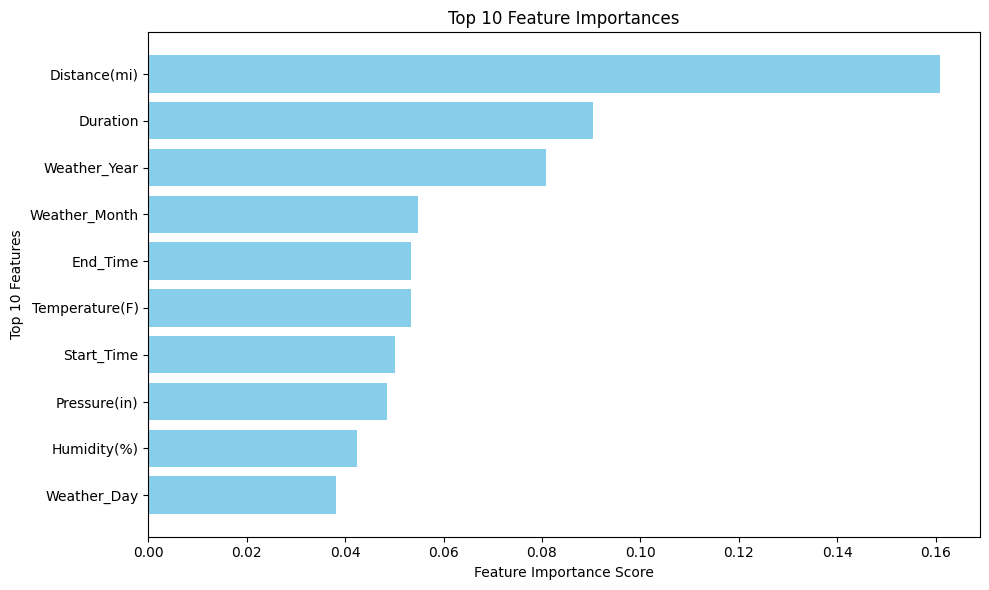

In [58]:
plot_top_feature_importances(model, X_train, selector=None, top_n=10)

# Backward Selection

In [60]:
def feature_selection_evaluate(n_features, X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state=42)
    selector = RFE(model, n_features_to_select=n_features, step=1)

    # Train a new Random Forest model on the reduced feature set
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    print("Selected features: ", selected_features)

    # Transform both training and validation datasets
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)

    model.fit(X_train_selected, y_train)

    y_pred_validate = model.predict(X_validate_selected)
    evaluate(y_pred_validate, y_validate, X_validate_selected, model)

    y_pred_test = model.predict(X_test_selected)
    evaluate(y_pred_test, y_test, X_test_selected, model)

    plot_top_feature_importances(model, X_train, selector=selector, top_n=n_features)

    return selector

Selected features:  Index(['Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Traffic_Signal',
       'Duration', 'Region', 'State_Others', 'Weather_Year', 'Weather_Month',
       'Weather_Day', 'Weather_Hour'],
      dtype='object')
Accuracy: 0.519
F1 Score: 0.5907711934254388
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.97      0.47      0.63       828
           3       0.33      0.73      0.45       124
           4       0.10      0.76      0.18        34

    accuracy                           0.52      1000
   macro avg       0.40      0.74      0.41      1000
weighted avg       0.85      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 37 389 182 220]
 [ 12   8  90  14]
 [  0   5   3  26]]
Accuracy1 (Exact match): 0.519
Accuracy2 (One-off accuracy): 0.763


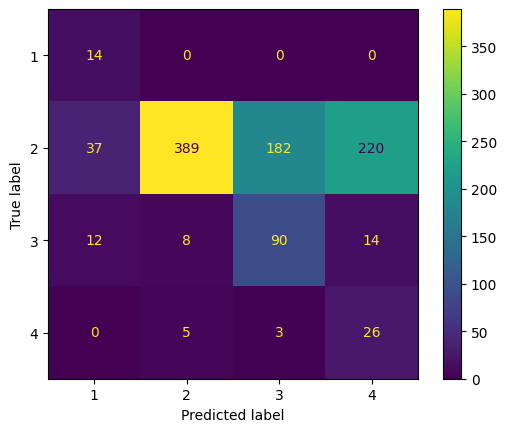

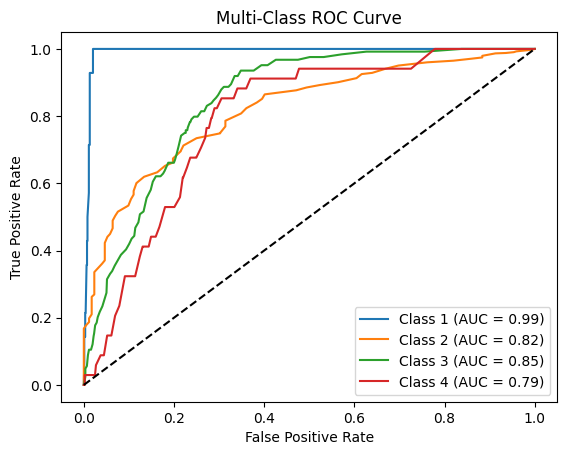

Accuracy: 0.526
F1 Score: 0.6179582123365364
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.50      0.66       857
           3       0.32      0.69      0.44       119
           4       0.05      0.72      0.09        18

    accuracy                           0.53      1000
   macro avg       0.37      0.73      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 31 425 172 229]
 [ 13  10  82  14]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.526
Accuracy2 (One-off accuracy): 0.755


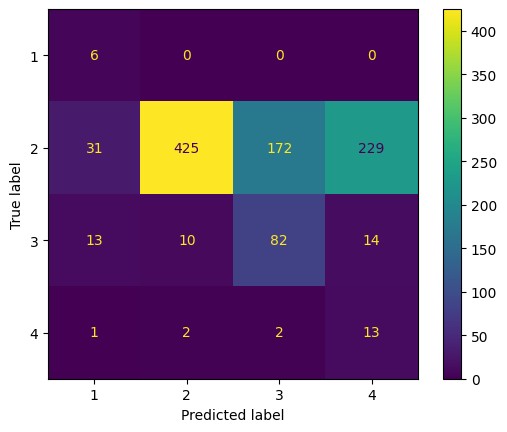

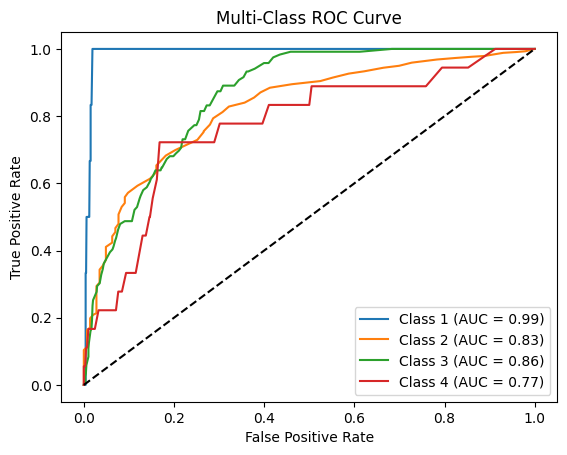

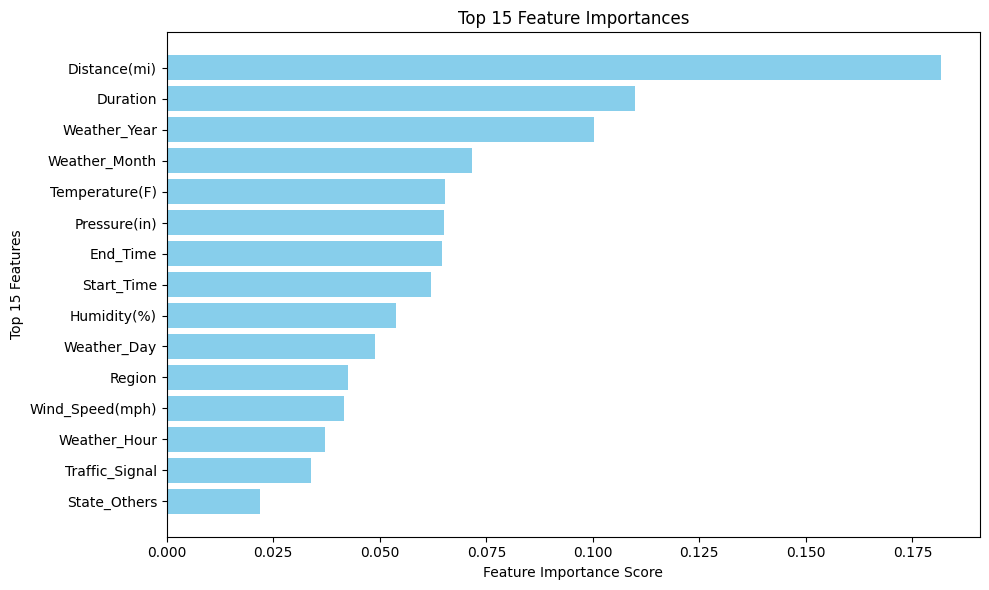

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=15)

In [61]:
feature_selection_evaluate(15, X_train, y_train, X_test, y_test)

Selected features:  Index(['Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Crossing', 'Traffic_Signal', 'Duration', 'Region',
       'State_CA', 'State_Others', 'Weather_Condition_Encoded', 'Weather_Year',
       'Weather_Month', 'Weather_Day', 'Weather_Hour'],
      dtype='object')
Accuracy: 0.528
F1 Score: 0.6010125451112917
Classification Report:
               precision    recall  f1-score   support

           1       0.20      1.00      0.33        14
           2       0.97      0.48      0.65       828
           3       0.33      0.69      0.45       124
           4       0.11      0.82      0.19        34

    accuracy                           0.53      1000
   macro avg       0.40      0.75      0.40      1000
weighted avg       0.85      0.53      0.60      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 43 400 170 215]
 [ 14   9  86  15]
 [  0   3   3  28]]


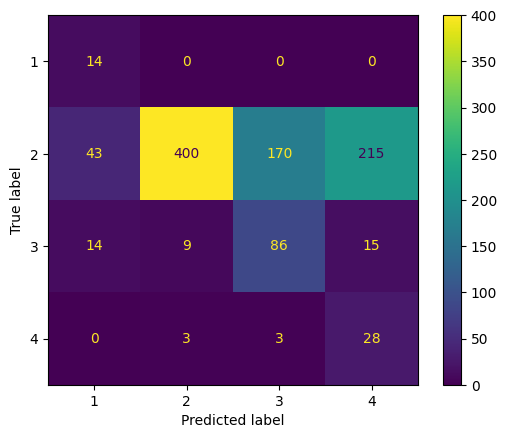

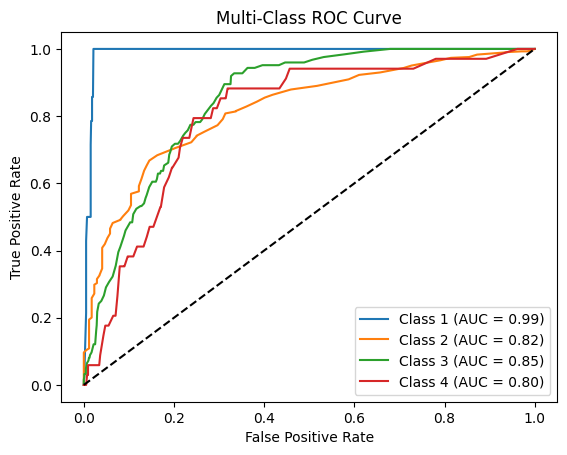

Accuracy: 0.537
F1 Score: 0.6303027859743904
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.19         6
           2       0.97      0.51      0.67       857
           3       0.33      0.68      0.44       119
           4       0.04      0.61      0.08        18

    accuracy                           0.54      1000
   macro avg       0.36      0.70      0.35      1000
weighted avg       0.87      0.54      0.63      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 35 439 163 220]
 [ 14   9  81  15]
 [  1   4   2  11]]
Accuracy1 (Exact match): 0.537
Accuracy2 (One-off accuracy): 0.761


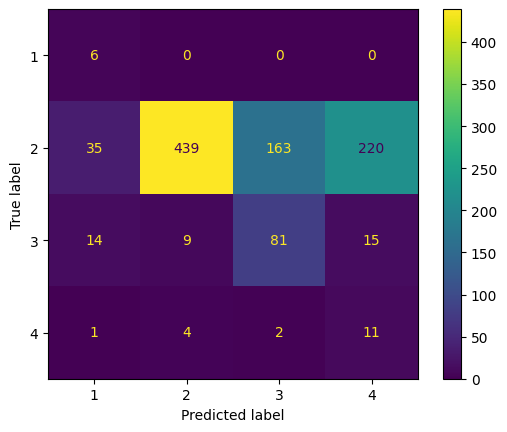

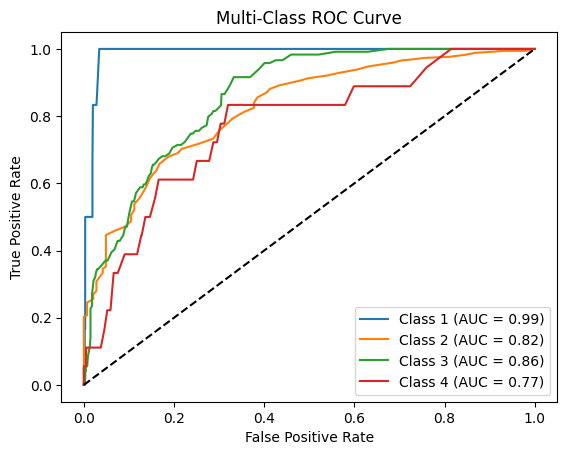

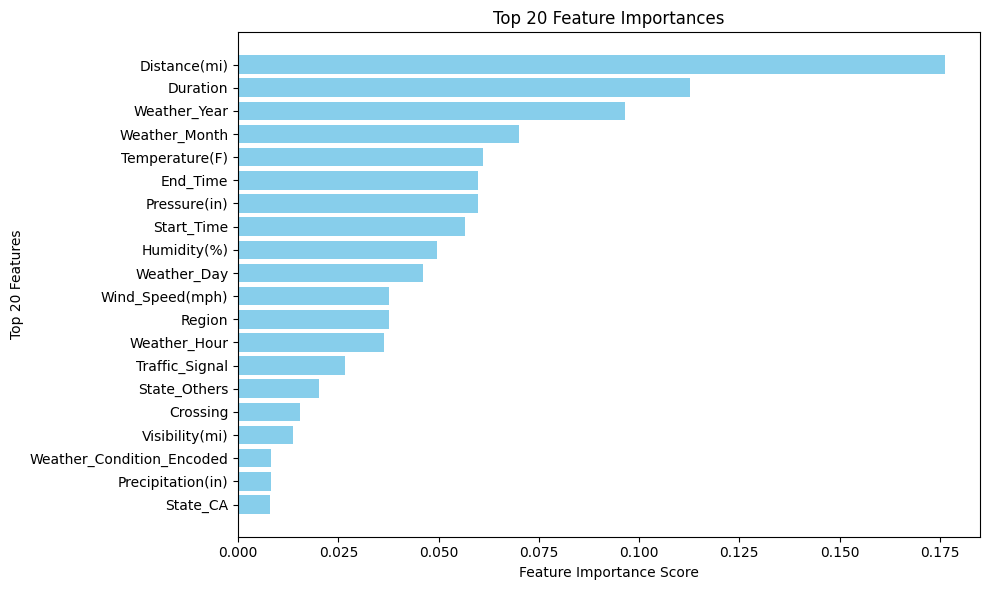

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=20)

In [62]:
feature_selection_evaluate(20, X_train, y_train, X_test, y_test)

Selected features:  Index(['Weather_Day_of_Week_Monday', 'Weather_Day_of_Week_Thursday',
       'Weather_Day_of_Week_Tuesday', 'Weather_Day_of_Week_Wednesday',
       'Start_Time', 'End_Time', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Crossing', 'Traffic_Signal', 'Duration', 'Region',
       'State_CA', 'State_Others', 'City_Others', 'Weather_Condition_Encoded',
       'Weather_Year', 'Weather_Month', 'Weather_Day', 'Weather_Hour'],
      dtype='object')
Accuracy: 0.529
F1 Score: 0.6020004106523635
Classification Report:
               precision    recall  f1-score   support

           1       0.20      1.00      0.33        14
           2       0.98      0.48      0.64       828
           3       0.34      0.73      0.47       124
           4       0.10      0.76      0.18        34

    accuracy                           0.53      1000
   macro avg       0.41      0.74      0.41      1

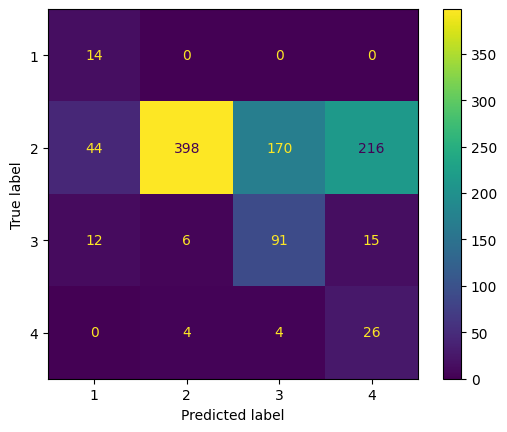

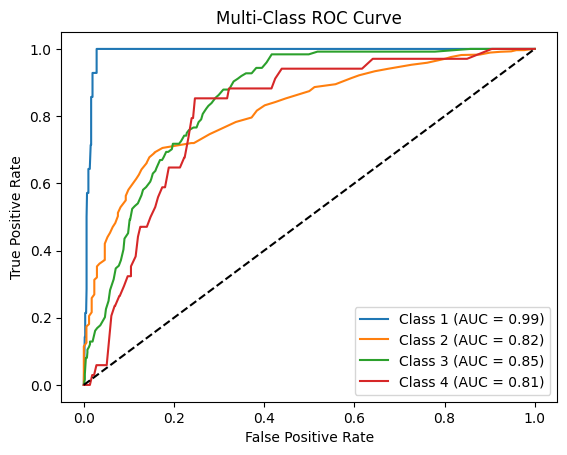

Accuracy: 0.523
F1 Score: 0.616427804562851
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.97      0.50      0.66       857
           3       0.32      0.66      0.43       119
           4       0.05      0.72      0.09        18

    accuracy                           0.52      1000
   macro avg       0.36      0.72      0.35      1000
weighted avg       0.87      0.52      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 32 426 165 234]
 [ 14  13  78  14]
 [  1   2   2  13]]
Accuracy1 (Exact match): 0.523
Accuracy2 (One-off accuracy): 0.749


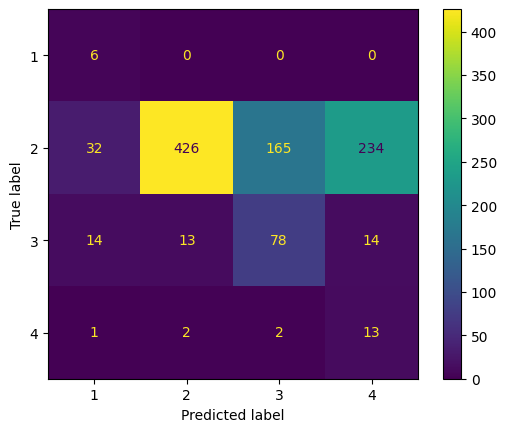

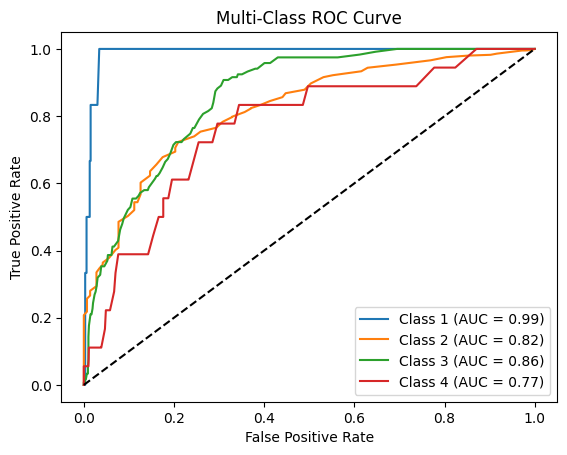

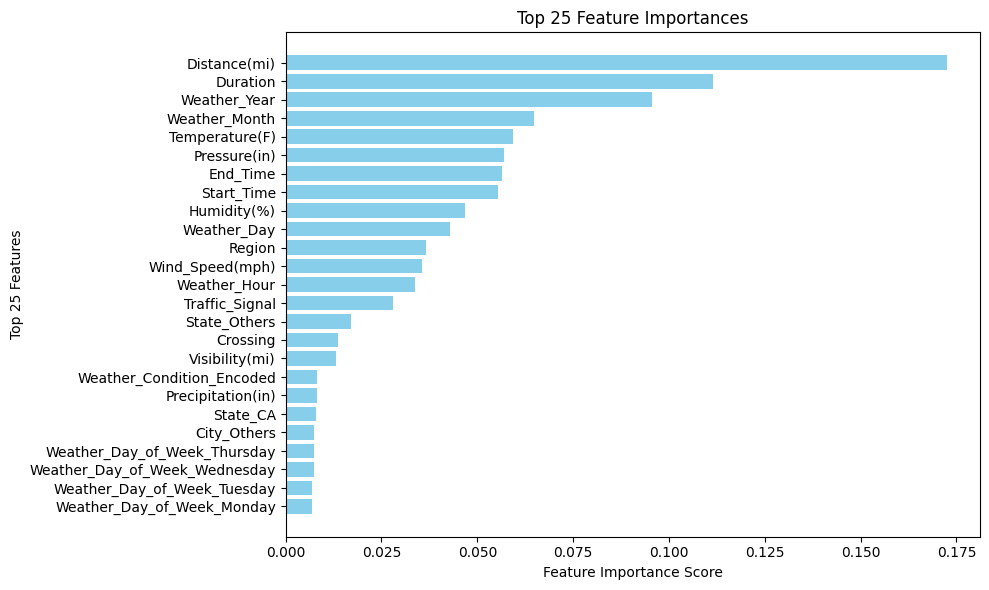

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=25)

In [63]:
feature_selection_evaluate(25, X_train, y_train, X_test, y_test)

# Parameter Tuning

In [71]:
from sklearn.metrics import make_scorer

def tune_rf_with_rfe(X_train, y_train, X_validate, y_validate, X_test, y_test, param_grid, n_features=20):
    """
    Perform Recursive Feature Elimination (RFE) with RandomForest, followed by hyperparameter tuning 
    using GridSearchCV with F1 scoring and 5-fold cross-validation.

    Parameters:
    - X_train, y_train: Training data and labels
    - X_validate, y_validate: Validation data and labels
    - X_test, y_test: Test data and labels
    - n_features: Number of features to select using RFE

    Returns:
    - best_model: The best Random Forest model after tuning
    """
    
    # Step 1: Perform Recursive Feature Elimination (RFE)
    selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train)

    # Select only important features
    X_train_selected = selector.transform(X_train)
    X_validate_selected = selector.transform(X_validate)
    X_test_selected = selector.transform(X_test)


    # Define a custom scorer for F1 (weighted)
    f1_scorer = make_scorer(f1_score, average='weighted')

    # Step 3: Initialize GridSearchCV with cross-validation and F1 scorer
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,  # Cross-validation folds
        scoring=f1_scorer,  # Use F1 weighted scorer
        n_jobs=-1,  # Use all available CPUs
        verbose=2
    )

    # Step 4: Fit the grid search to the **selected feature** training data
    grid_search.fit(X_train_selected, y_train)

    # Step 5: Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters found: ", grid_search.best_params_)

    # Step 6: Make predictions using the best model on the validation set
    y_pred_validate = best_model.predict(X_validate_selected)
    print("\nEvaluate (Validation Set):")
    evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)

    # Step 7: Evaluate on the test set
    y_pred_test = best_model.predict(X_test_selected)
    print("\nEvaluate (Test Set):")
    evaluate(y_pred_test, y_test, X_test_selected, best_model)

    plot_top_feature_importances(best_model, X_train, selector=selector, top_n=n_features)
    return best_model


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END ccp_

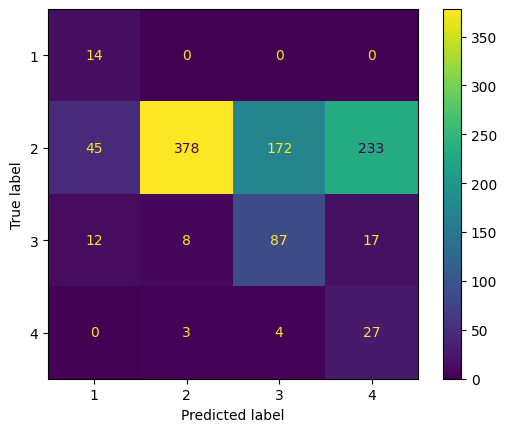

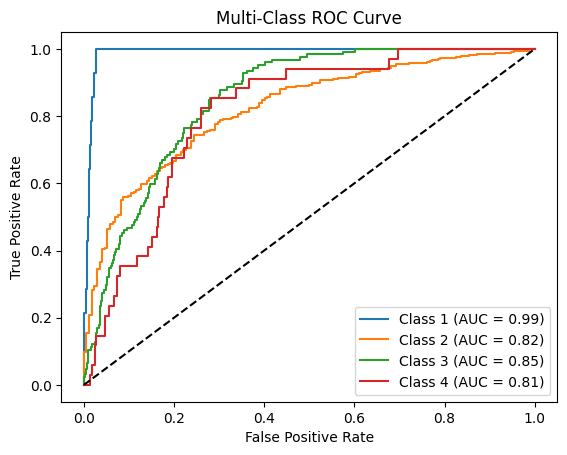


Evaluate (Test Set):
Accuracy: 0.517
F1 Score: 0.6116980799793514
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.97      0.49      0.65       857
           3       0.32      0.66      0.43       119
           4       0.05      0.67      0.09        18

    accuracy                           0.52      1000
   macro avg       0.36      0.71      0.34      1000
weighted avg       0.87      0.52      0.61      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 35 420 166 236]
 [ 13  11  79  16]
 [  1   3   2  12]]
Accuracy1 (Exact match): 0.517
Accuracy2 (One-off accuracy): 0.747


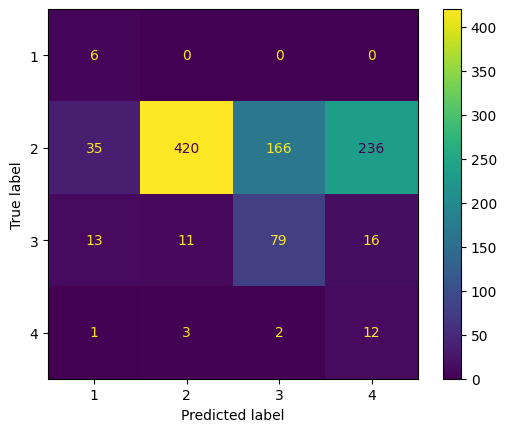

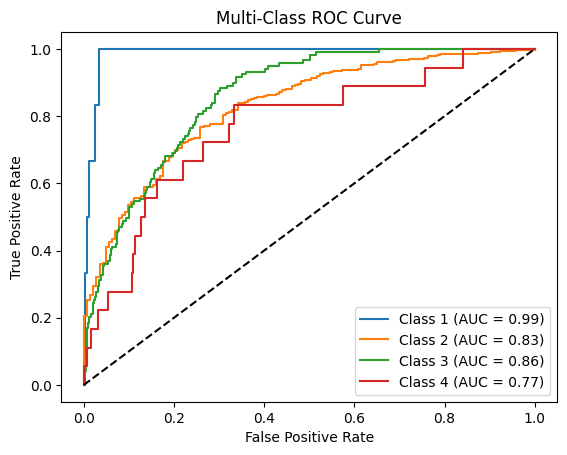

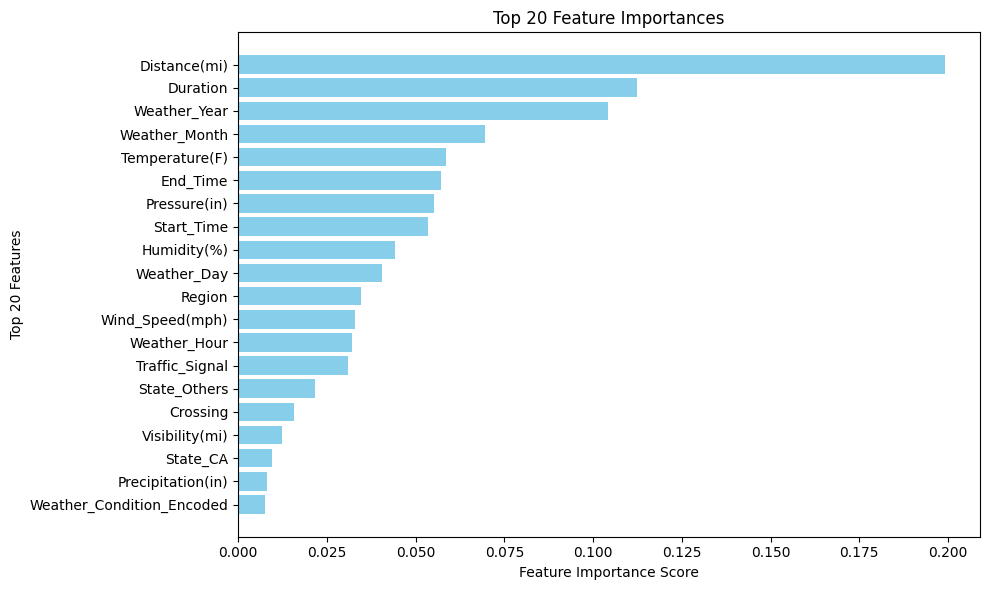

In [73]:
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'ccp_alpha': [0.0, 0.01, 0.1],  
    'max_samples': [None, 0.5, 0.8]  
}
best_model = tune_rf_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20  
)

Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 20, 'max_samples': 0.8, 'min_samples_split': 5, 'n_estimators': 150}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.6, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=15, max_samples=0.

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
 

Best parameters found:  {'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 1.0, 'min_samples_split': 3, 'n_estimators': 200}

Evaluate (Validation Set):
Accuracy: 0.51
F1 Score: 0.5830574082606773
Classification Report:
               precision    recall  f1-score   support

           1       0.21      1.00      0.35        14
           2       0.97      0.46      0.62       828
           3       0.34      0.73      0.46       124
           4       0.10      0.82      0.18        34

    accuracy                           0.51      1000
   macro avg       0.41      0.75      0.40      1000
weighted avg       0.86      0.51      0.58      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 41 378 172 237]
 [ 12   7  90  15]
 [  0   3   3  28]]
Accuracy1 (Exact match): 0.51
Accuracy2 (One-off accuracy): 0.748


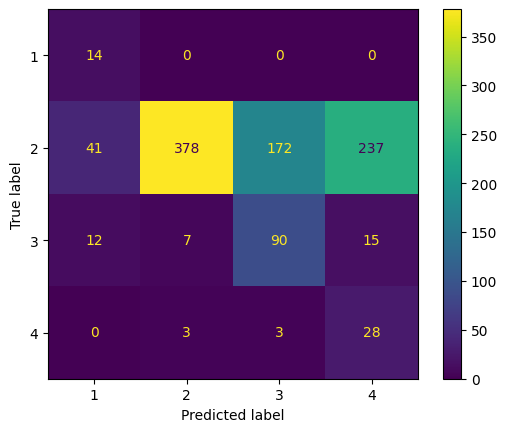

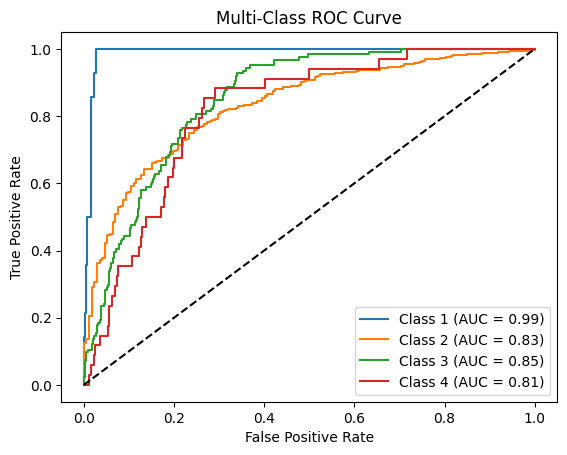


Evaluate (Test Set):
Accuracy: 0.515
F1 Score: 0.6100147613661712
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.19         6
           2       0.97      0.49      0.65       857
           3       0.32      0.66      0.43       119
           4       0.05      0.67      0.08        18

    accuracy                           0.52      1000
   macro avg       0.36      0.70      0.34      1000
weighted avg       0.87      0.52      0.61      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 36 418 165 238]
 [ 13  11  79  16]
 [  1   3   2  12]]
Accuracy1 (Exact match): 0.515
Accuracy2 (One-off accuracy): 0.745


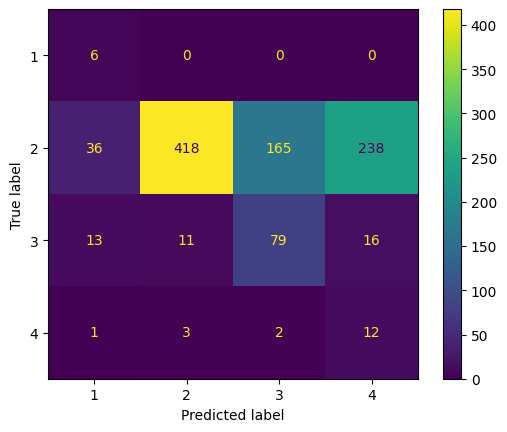

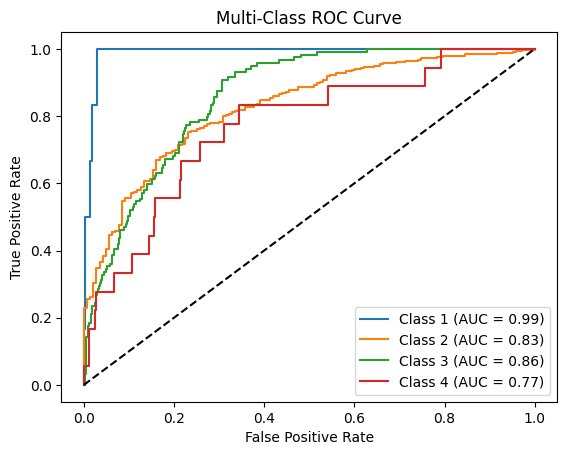

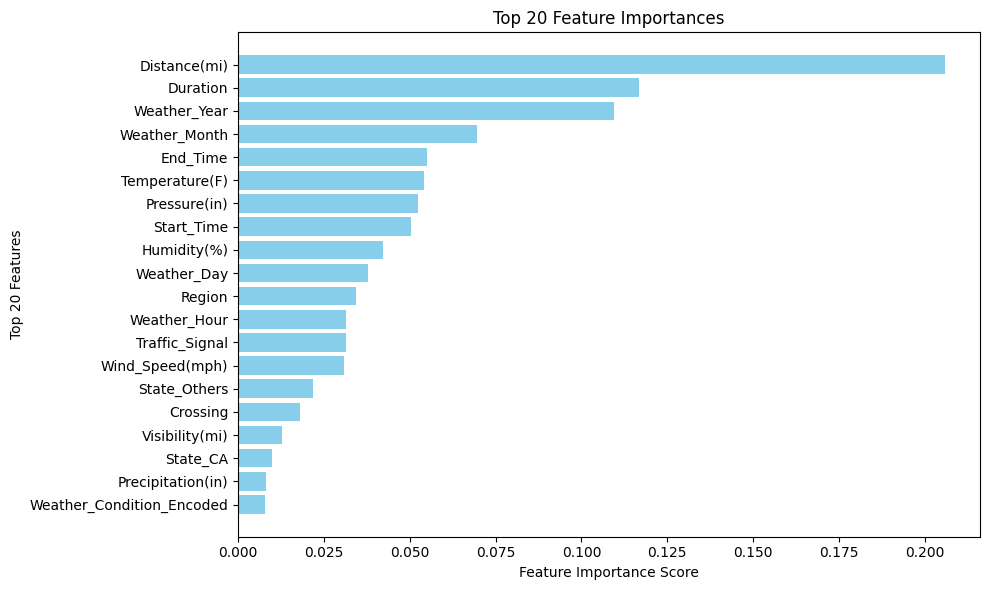

In [72]:
param_grid = {
    'n_estimators': [130, 170, 200],  
    'max_depth': [15, 25],  
    'min_samples_split': [1, 3, 7],  
    'ccp_alpha': [0, 0.001],  
    'max_samples': [0.6, 1.0]  
}
best_model = tune_rf_with_rfe(
    X_train, y_train, 
    X_validate, y_validate, 
    X_test, y_test, 
    param_grid=param_grid,
    n_features=20  
)


Best parameters found:  {'ccp_alpha': 0, 'max_depth': 15, 'max_samples': 1.0, 'min_samples_split': 3, 'n_estimators': 200}
